In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

In [29]:
data_dir = '../data/RealWaste'
classes = ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal',
           '5-Miscellaneous Trash', '6-Paper', '7-Plastic',
           '8-Textile Trash', '9-Vegetation']
img_size = (224, 224)
batch_size = 8

In [31]:
train_paths = []
train_labels = []
test_paths = []
test_labels = []

for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)
    split_idx = int(0.8 * len(image_files))

    for img_file in image_files[:split_idx]:
        train_paths.append(os.path.join(class_dir, img_file))
        train_labels.append(class_name)

    for img_file in image_files[split_idx:]:
        test_paths.append(os.path.join(class_dir, img_file))
        test_labels.append(class_name)

label_binarizer = LabelBinarizer()
train_labels_one_hot = label_binarizer.fit_transform(train_labels)
test_labels_one_hot = label_binarizer.transform(test_labels)
num_classes = 9

train_paths, val_paths, train_labels_one_hot, val_labels_one_hot = train_test_split(
    train_paths, train_labels_one_hot, test_size=0.2, stratify=train_labels, random_state=42)


print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

Training samples: 3038
Validation samples: 760
Test samples: 954


In [33]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest')

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

def create_data_generator(paths, labels, generator, batch_size, shuffle=False):
    def path_generator():
        for path, label in zip(paths, labels):
            yield path, label

    dataset = tf.data.Dataset.from_generator(
        path_generator,
        output_types=(tf.string, tf.float32),
        output_shapes=((), (num_classes,))
    )

    dataset = dataset.map(lambda path, label: load_and_preprocess_image(path, label))
    dataset = dataset.batch(batch_size)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(paths))
    return dataset

train_dataset = create_data_generator(train_paths, train_labels_one_hot, train_datagen, batch_size, shuffle=True)
val_dataset = create_data_generator(val_paths, val_labels_one_hot, val_test_datagen, batch_size)
test_dataset = create_data_generator(test_paths, test_labels_one_hot, val_test_datagen, batch_size)


In [35]:
def build_transfer_model(base_model, input_shape=(224, 224, 3), num_classes=9):
    base_model.trainable = False

    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                          keras.metrics.AUC(name='auc')])
    return model

models_dict = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'ResNet101': ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'EfficientNetB0': EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

trained_models = {}
for name, base_model in models_dict.items():
    print(f"\nBuilding {name} model...")
    trained_models[name] = build_transfer_model(base_model, num_classes=num_classes)


Building ResNet50 model...

Building ResNet101 model...

Building EfficientNetB0 model...

Building VGG16 model...



Training ResNet50 model...
Epoch 1/50
    380/Unknown 72s 176ms/step - accuracy: 0.5645 - auc: 0.8914 - loss: 4.2738 - precision: 0.7078 - recall: 0.4373

380/380 ━━━━━━━━━━━━━━━━━━━━ 90s 223ms/step - accuracy: 0.5648 - auc: 0.8915 - loss: 4.2710 - precision: 0.7080 - recall: 0.4376 - val_accuracy: 0.7105 - val_auc: 0.9597 - val_loss: 2.0388 - val_precision: 0.7601 - val_recall: 0.6711
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.7852 - auc: 0.9755 - loss: 1.6665 - precision: 0.8348 - recall: 0.7350

380/380 ━━━━━━━━━━━━━━━━━━━━ 92s 237ms/step - accuracy: 0.7852 - auc: 0.9755 - loss: 1.6663 - precision: 0.8348 - recall: 0.7349 - val_accuracy: 0.7395 - val_auc: 0.9638 - val_loss: 1.5802 - val_precision: 0.7723 - val_recall: 0.7053
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8205 - auc: 0.9829 - loss: 1.2418 - precision: 0.8669 - recall: 0.7743

380/380 ━━━━━━━━━━━━━━━━━━━━ 92s 238ms/step - accuracy: 0.8204 - auc: 0.9829 - loss: 1.2419 - precision: 0.8668 - recall: 0.7742 - val_accuracy: 0.7776 - val_auc: 0.9689 - val_loss: 1.4202 - val_precision: 0.8122 - val_recall: 0.7513
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 94s 244ms/step - accuracy: 0.8237 - auc: 0.9840 - loss: 1.1595 - precision: 0.8654 - recall: 0.7893 - val_accuracy: 0.7026 - val_auc: 0.9520 - val_loss: 1.5859 - val_precision: 0.7425 - val_recall: 0.6829
Epoch 5/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.8428 - auc: 0.9853 - loss: 1.0950 - precision: 0.8768 - recall: 0.8014

380/380 ━━━━━━━━━━━━━━━━━━━━ 94s 242ms/step - accuracy: 0.8428 - auc: 0.9853 - loss: 1.0952 - precision: 0.8767 - recall: 0.8013 - val_accuracy: 0.7461 - val_auc: 0.9636 - val_loss: 1.3969 - val_precision: 0.7786 - val_recall: 0.7171
Epoch 6/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 97s 250ms/step - accuracy: 0.8442 - auc: 0.9856 - loss: 1.0669 - precision: 0.8783 - recall: 0.8052 - val_accuracy: 0.5974 - val_auc: 0.9046 - val_loss: 2.0869 - val_precision: 0.6311 - val_recall: 0.5763
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8463 - auc: 0.9875 - loss: 0.9960 - precision: 0.8822 - recall: 0.8155

380/380 ━━━━━━━━━━━━━━━━━━━━ 94s 243ms/step - accuracy: 0.8463 - auc: 0.9875 - loss: 0.9961 - precision: 0.8822 - recall: 0.8155 - val_accuracy: 0.7947 - val_auc: 0.9696 - val_loss: 1.2379 - val_precision: 0.8220 - val_recall: 0.7776
Epoch 8/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 94s 244ms/step - accuracy: 0.8723 - auc: 0.9897 - loss: 0.9256 - precision: 0.8981 - recall: 0.8450 - val_accuracy: 0.7816 - val_auc: 0.9715 - val_loss: 1.2773 - val_precision: 0.8127 - val_recall: 0.7592
Epoch 9/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 94s 244ms/step - accuracy: 0.8572 - auc: 0.9897 - loss: 0.9570 - precision: 0.8878 - recall: 0.8222 - val_accuracy: 0.7645 - val_auc: 0.9701 - val_loss: 1.2690 - val_precision: 0.7848 - val_recall: 0.7487
Epoch 10/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 98s 253ms/step - accuracy: 0.8601 - auc: 0.9894 - loss: 0.9370 - precision: 0.8916 - recall: 0.8325 - val_accuracy: 0.6092 - val_auc: 0.8886 - val_loss: 2.4619 - val_precision: 0.6290 - val_recall: 0.6000
Epoch 11/50
380/380 ━━━━━━━━━━

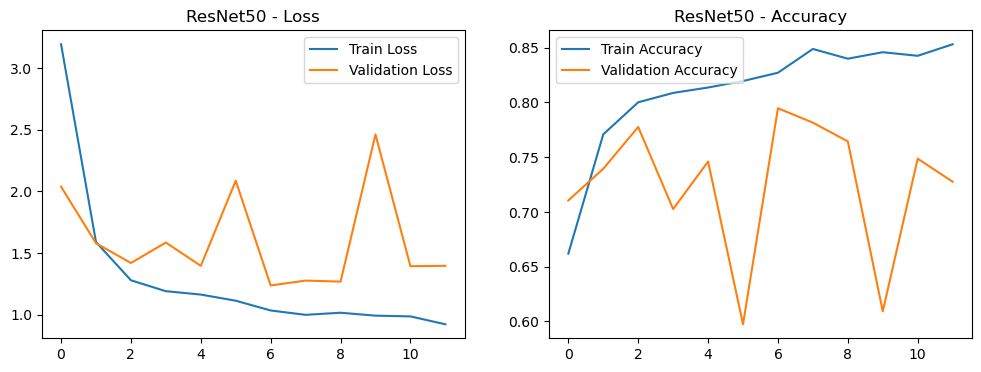


Training ResNet101 model...
Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 181s 462ms/step - accuracy: 0.5638 - auc: 0.8884 - loss: 4.3578 - precision: 0.6994 - recall: 0.4413 - val_accuracy: 0.7289 - val_auc: 0.9594 - val_loss: 2.0825 - val_precision: 0.7861 - val_recall: 0.6868
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 187s 486ms/step - accuracy: 0.7742 - auc: 0.9757 - loss: 1.7117 - precision: 0.8352 - recall: 0.7277 - val_accuracy: 0.6039 - val_auc: 0.9239 - val_loss: 2.0403 - val_precision: 0.6503 - val_recall: 0.5750
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 172s 449ms/step - accuracy: 0.7871 - auc: 0.9782 - loss: 1.3806 - precision: 0.8279 - recall: 0.7300 - val_accuracy: 0.7553 - val_auc: 0.9640 - val_loss: 1.4730 - val_precision: 0.8023 - val_recall: 0.7211
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 265s 694ms/step - accuracy: 0.8254 - auc: 0.9840 - loss: 1.1859 - precision: 0.8672 - recall: 0.7805 - val_accuracy: 0.6461 - val_auc: 0.9278 - val_loss: 1.9092 - val_precision: 0.6690 - val_re

2025-05-10 15:54:42.552920: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


380/380 ━━━━━━━━━━━━━━━━━━━━ 284s 743ms/step - accuracy: 0.8291 - auc: 0.9837 - loss: 1.1311 - precision: 0.8676 - recall: 0.7937 - val_accuracy: 0.7526 - val_auc: 0.9611 - val_loss: 1.4341 - val_precision: 0.7768 - val_recall: 0.7145
Epoch 7/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 162s 423ms/step - accuracy: 0.8488 - auc: 0.9869 - loss: 1.0514 - precision: 0.8825 - recall: 0.8170 - val_accuracy: 0.7434 - val_auc: 0.9567 - val_loss: 1.4858 - val_precision: 0.7839 - val_recall: 0.7158
Epoch 8/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 169s 441ms/step - accuracy: 0.8439 - auc: 0.9885 - loss: 1.0261 - precision: 0.8772 - recall: 0.8044 - val_accuracy: 0.7632 - val_auc: 0.9673 - val_loss: 1.3400 - val_precision: 0.7932 - val_recall: 0.7316
Epoch 9/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 172s 450ms/step - accuracy: 0.8634 - auc: 0.9878 - loss: 1.0229 - precision: 0.8890 - recall: 0.8264 - val_accuracy: 0.7658 - val_auc: 0.9705 - val_loss: 1.2605 - val_precision: 0.7908 - val_recall: 0.7461
Epoch 10/50
380/380 ━━━━━━━

380/380 ━━━━━━━━━━━━━━━━━━━━ 174s 453ms/step - accuracy: 0.8482 - auc: 0.9890 - loss: 0.9574 - precision: 0.8860 - recall: 0.8222 - val_accuracy: 0.7671 - val_auc: 0.9685 - val_loss: 1.2191 - val_precision: 0.7952 - val_recall: 0.7461
Epoch 12/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 417s 1s/step - accuracy: 0.8656 - auc: 0.9898 - loss: 0.8973 - precision: 0.8992 - recall: 0.8333 - val_accuracy: 0.7605 - val_auc: 0.9623 - val_loss: 1.3352 - val_precision: 0.7937 - val_recall: 0.7237
Epoch 13/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 168s 439ms/step - accuracy: 0.8732 - auc: 0.9904 - loss: 0.9156 - precision: 0.8985 - recall: 0.8364 - val_accuracy: 0.6645 - val_auc: 0.9312 - val_loss: 1.7663 - val_precision: 0.7130 - val_recall: 0.6408
Epoch 14/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 169s 441ms/step - accuracy: 0.8560 - auc: 0.9879 - loss: 0.9814 - precision: 0.8811 - recall: 0.8373 - val_accuracy: 0.7816 - val_auc: 0.9699 - val_loss: 1.2390 - val_precision: 0.8084 - val_recall: 0.7605
Epoch 15/50
380/380 ━━━━━━━

380/380 ━━━━━━━━━━━━━━━━━━━━ 171s 447ms/step - accuracy: 0.8655 - auc: 0.9918 - loss: 0.8892 - precision: 0.8965 - recall: 0.8369 - val_accuracy: 0.8342 - val_auc: 0.9748 - val_loss: 1.0988 - val_precision: 0.8507 - val_recall: 0.8171
Epoch 17/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 176s 458ms/step - accuracy: 0.8764 - auc: 0.9910 - loss: 0.8613 - precision: 0.8987 - recall: 0.8511 - val_accuracy: 0.7671 - val_auc: 0.9658 - val_loss: 1.2464 - val_precision: 0.7925 - val_recall: 0.7487
Epoch 18/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 176s 459ms/step - accuracy: 0.8777 - auc: 0.9919 - loss: 0.8374 - precision: 0.8998 - recall: 0.8551 - val_accuracy: 0.7895 - val_auc: 0.9689 - val_loss: 1.1388 - val_precision: 0.8141 - val_recall: 0.7724
Epoch 19/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 178s 464ms/step - accuracy: 0.8735 - auc: 0.9921 - loss: 0.8070 - precision: 0.8937 - recall: 0.8499 - val_accuracy: 0.8118 - val_auc: 0.9719 - val_loss: 1.1298 - val_precision: 0.8315 - val_recall: 0.7921
Epoch 20/50
380/380 ━━━━

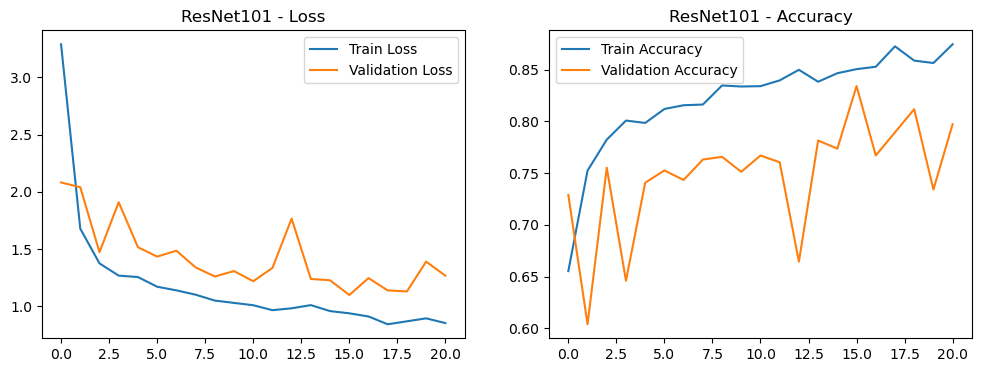


Training EfficientNetB0 model...
Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.4912 - auc: 0.8476 - loss: 4.9310 - precision: 0.6217 - recall: 0.3509 - val_accuracy: 0.7105 - val_auc: 0.9571 - val_loss: 2.6242 - val_precision: 0.7852 - val_recall: 0.6303
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 36s 90ms/step - accuracy: 0.7128 - auc: 0.9533 - loss: 2.3887 - precision: 0.7930 - recall: 0.6231 - val_accuracy: 0.6842 - val_auc: 0.9458 - val_loss: 1.9921 - val_precision: 0.7391 - val_recall: 0.6224
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 36s 91ms/step - accuracy: 0.7301 - auc: 0.9577 - loss: 1.7901 - precision: 0.7951 - recall: 0.6511 - val_accuracy: 0.6921 - val_auc: 0.9469 - val_loss: 1.8001 - val_precision: 0.7398 - val_recall: 0.6434
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 37s 93ms/step - accuracy: 0.7207 - auc: 0.9626 - loss: 1.5867 - precision: 0.7922 - recall: 0.6566 - val_accuracy: 0.6789 - val_auc: 0.9493 - val_loss: 1.7241 - val_precision: 0.7365 - val_recal

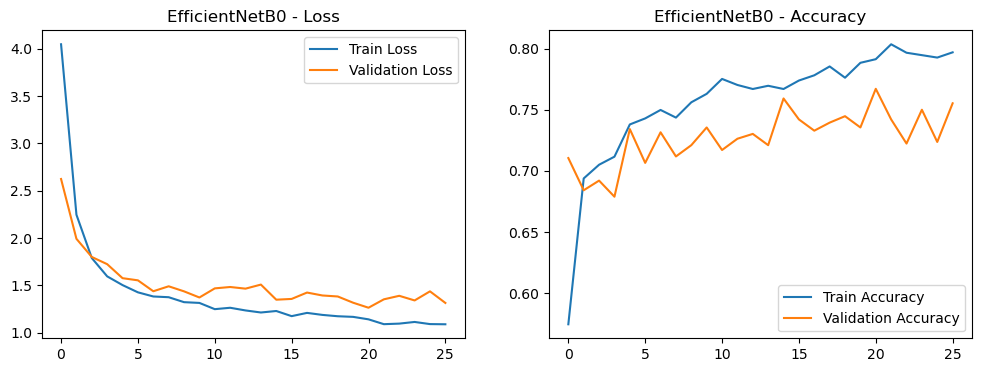


Training VGG16 model...
Epoch 1/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 300s 785ms/step - accuracy: 0.5058 - auc: 0.8537 - loss: 3.9416 - precision: 0.6573 - recall: 0.3675 - val_accuracy: 0.7382 - val_auc: 0.9544 - val_loss: 2.2821 - val_precision: 0.8000 - val_recall: 0.6842
Epoch 2/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.7828 - auc: 0.9717 - loss: 1.9383 - precision: 0.8296 - recall: 0.7074 - val_accuracy: 0.7868 - val_auc: 0.9696 - val_loss: 1.6443 - val_precision: 0.8239 - val_recall: 0.7447
Epoch 3/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 627s 2s/step - accuracy: 0.8090 - auc: 0.9811 - loss: 1.4239 - precision: 0.8521 - recall: 0.7662 - val_accuracy: 0.7461 - val_auc: 0.9622 - val_loss: 1.5133 - val_precision: 0.7894 - val_recall: 0.7053
Epoch 4/50
380/380 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.8228 - auc: 0.9856 - loss: 1.1857 - precision: 0.8675 - recall: 0.7828 - val_accuracy: 0.7553 - val_auc: 0.9639 - val_loss: 1.3873 - val_precision: 0.7951 - val_recall: 0.7250


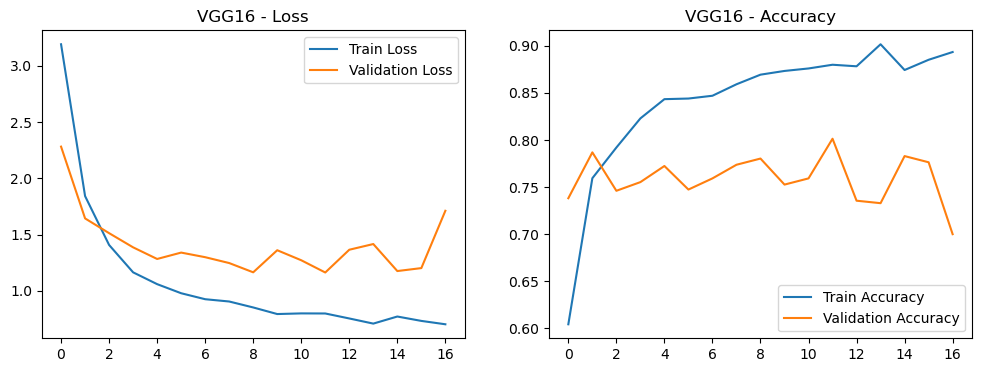

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history_dict = {}
epochs = 50

for name, model in trained_models.items():
    print(f"\nTraining {name} model...")
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )
    history_dict[name] = history

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{name} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.legend()
    plt.show()


In [45]:
final_results = {}
for name, model in trained_models.items():
    print(f"\nEvaluating {name} model:")
    y_true = []
    y_pred = []
    for images, labels in test_dataset:
        batch_pred = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1)) 
        y_pred.extend(np.argmax(batch_pred, axis=1))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    test_results = model.evaluate(test_dataset, verbose=0)
    
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_true, y_pred, target_names=classes))
    final_results[name] = {
        'test_loss': test_results[0],
        'test_accuracy': test_results[1],
        'test_precision': test_results[2],
        'test_recall': test_results[3],
        'test_auc': test_results[4],
        'classification_report': classification_report(y_true, y_pred, target_names=classes, output_dict=True) }

print("Model Comparison:")
comparison_df = pd.DataFrame.from_dict({k: {
    'Accuracy': v['test_accuracy'],
    'Precision': v['test_precision'],
    'Recall': v['test_recall'],
    'AUC': v['test_auc'],
    'F1-Score': v['classification_report']['macro avg']['f1-score']} for k, v in final_results.items()}, orient='index')

print(comparison_df)


Evaluating ResNet50 model:

Classification Report for ResNet50:
                       precision    recall  f1-score   support

          1-Cardboard       0.81      0.75      0.78        93
      2-Food Organics       0.85      0.61      0.71        83
              3-Glass       0.81      0.69      0.74        84
              4-Metal       0.67      0.88      0.76       158
5-Miscellaneous Trash       0.61      0.69      0.65        99
              6-Paper       0.77      0.71      0.74       100
            7-Plastic       0.81      0.69      0.75       185
      8-Textile Trash       0.73      0.89      0.80        64
         9-Vegetation       0.88      0.88      0.88        88

             accuracy                           0.75       954
            macro avg       0.77      0.75      0.76       954
         weighted avg       0.77      0.75      0.75       954


Evaluating ResNet101 model:

Classification Report for ResNet101:
                       precision    recall  f1

References: <br>
https://www.tensorflow.org/guide/keras/transfer_learning <br>
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications <br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html <br>
https://ai.google.dev/edge/litert/models/convert